In [6]:
# # os.chdir('..')
# !rm -r mae
# !git clone -b bootstrap-test https://github.com/kingjuno/mae
# import os
# os.chdir('mae')
# !pip install timm==0.3.2
# !pip install torch==1.8 torchvision==0.9

In [7]:
import sys
import os
os.chdir('/media/juno/research/mae')
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import models_mae_deit

In [8]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
mean=[0.4914, 0.4822, 0.4465]
std=[0.2470, 0.2435, 0.2616]
def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    # model = getattr(models_mae, arch)()
    model = models_mae_deit.MaskedAutoencoderDeiT(
        img_size=32,
        patch_size=4,
#         norm_pix_loss=args.norm_pix_loss,
    )
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

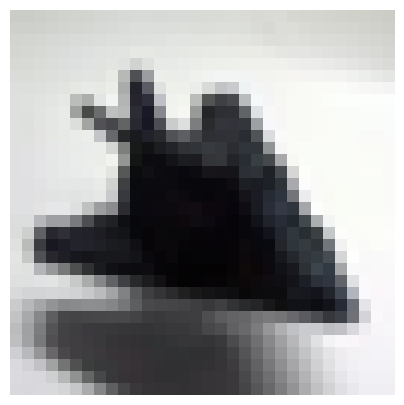

In [9]:
# load an image
# img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# # img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
# img = Image.open(requests.get(img_url, stream=True).raw)
# img = img.resize((128, 128))
img_url = 'data/train/airplane/0001.png'
img = Image.open(img_url)
img = np.array(img) / 255.

# assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))
# import torchvision
# from torchvision import transforms
# transform_train = transforms.Compose([
#             transforms.RandomResizedCrop(128),  # 3 is bicubic
# #             transforms.Resize((128,128)),
# #             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
# #             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ]
#     )
# # dataset_train = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform_train)
# # plt.imshow(dataset_train[120][0].permute(2,1,0)), dataset_train[0][0].shape
# # img = dataset_train[120][0]
# # img = img.resize((32, 32))
# # img = np.array(img) / 255.

# # # assert img.shape == (224, 224, 3)

# # # normalize by ImageNet mean and std
# # img = img - imagenet_mean
# # img = img / imagenet_std

# # plt.rcParams['figure.figsize'] = [5, 5]
# # show_image(torch.tensor(img))
# a = torchvision.datasets.ImageFolder(os.path.join('/kaggle/input/imagenetmini-1000/imagenet-mini/train'), transform=transform_train)
# plt.imshow(a[12][0].permute(1,2,0))
# img = a[120][0]

In [10]:
chkpt_dir = '/home/juno/Downloads/checkpoint-4 (1).pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_tiny_patch4')
print('Model loaded.')

AttributeError: module 'models_mae' has no attribute 'MaskedAutoencoderDeiT'

MAE with pixel reconstruction:


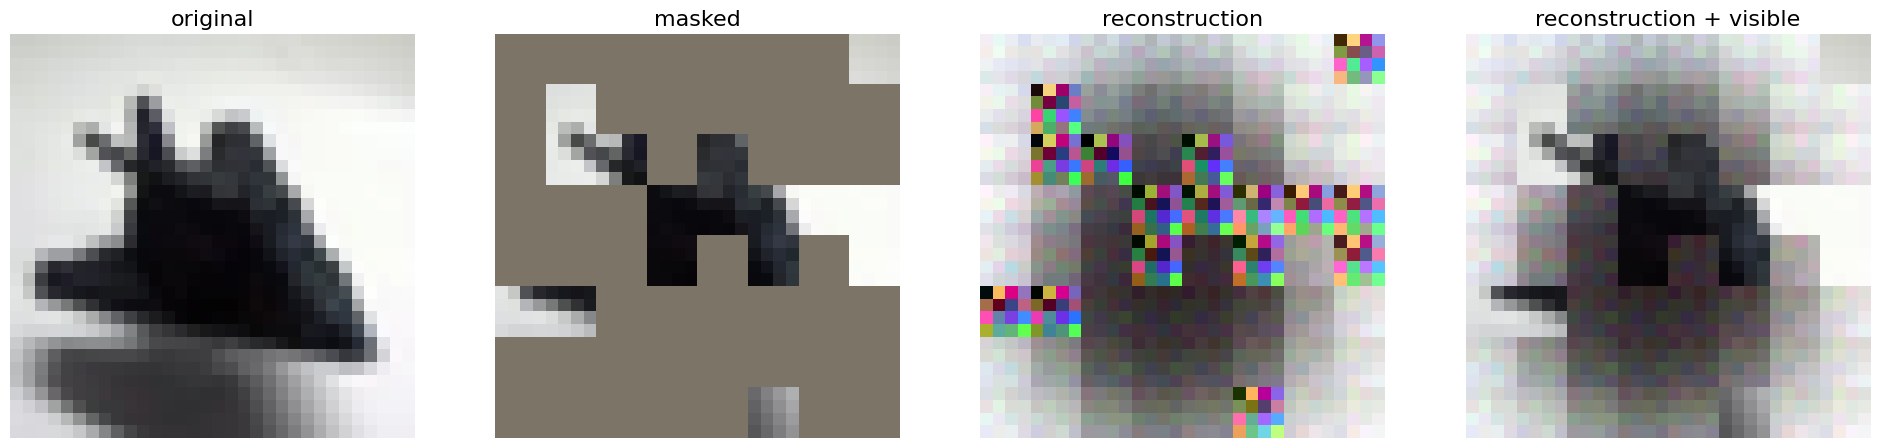

In [ ]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)